In [2]:
import torch

/home/holywater2/.conda/envs/infGCN/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
cutoff = lambda d,p: 1-(p+1)*(p+2)/2 * d**p + p*(p+2)*d**(p+1) - p*(p+1)*d**(p+2)/2

In [5]:
def envelope(d,exponent=1):
    p = exponent + 1
    a = -(p + 1) * (p + 2) / 2
    b = p * (p + 2)
    c = -p * (p + 1) / 2
    return 1/d + a * d**(p-1) + b * d**(p) + c * d**(p)


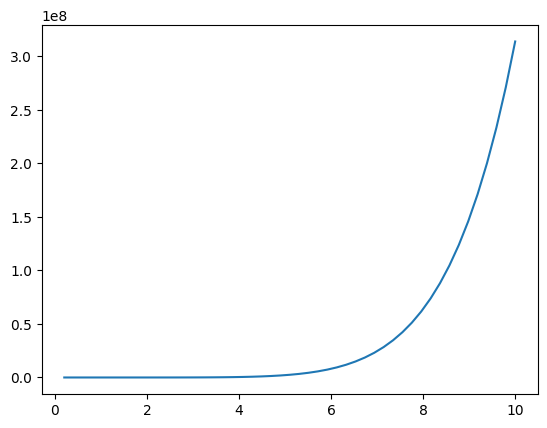

In [6]:
x = torch.linspace(0,10,50)
import matplotlib.pyplot as plt
plt.plot(x,envelope(x,6))

In [3]:
d = torch.rand(100,1,1,1,1,1,1,1,1,1,1) #batch 100, 10 features, 3 points

In [4]:
d = torch.rand(100,1,1,1,1,1,1,1,1,1,1) #batch 100, 10 features, 3 points

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


torch.manual_seed(0)
np.random.seed(0)


################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(13, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

In [4]:
x = torch.rand(32, 13).cuda()

In [5]:
modes = 8
width = 20

In [6]:
model = FNO3d(modes, modes, modes, width).cuda()

In [9]:
model(x)

IndexError: tuple index out of range

In [7]:
model.get_grid(x.shape, x.device).shape

IndexError: tuple index out of range

In [8]:
torch.cat((x, model.get_grid(x.shape, x.device)), dim=-1).shape

IndexError: tuple index out of range

In [10]:
torch.fft.nfft

AttributeError: module 'torch.fft' has no attribute 'nfft'

In [19]:
N = torch.linspace(0, 1, 2)
A = torch.meshgrid(N, N, N)

In [29]:
B = torch.stack([A[0].flatten(),A[1].flatten(),A[2].flatten()], dim=1)

In [31]:
B.shape

torch.Size([8, 3])

In [33]:
A[0].flatten()

tensor([0., 0., 0., 0., 1., 1., 1., 1.])

In [37]:
C = torch.stack(A,dim=-1)

In [40]:
C[0,0,1]

tensor([0., 0., 1.])

In [50]:
C.unsqueeze(0).repeat_interleave(10,dim=0).shape

torch.Size([10, 2, 2, 2, 3])

In [51]:
C

tensor([[[[0., 0., 0.],
          [0., 0., 1.]],

         [[0., 1., 0.],
          [0., 1., 1.]]],


        [[[1., 0., 0.],
          [1., 0., 1.]],

         [[1., 1., 0.],
          [1., 1., 1.]]]])

In [62]:
cell = torch.randn(2,3,3)
cell

tensor([[[ 0.1812,  1.6648, -0.4376],
         [ 0.0157, -0.2328,  0.1772],
         [ 0.0327, -0.7280,  0.8431]],

        [[-0.5054,  0.6311,  0.0516],
         [ 1.6499,  0.4475, -0.6226],
         [ 0.0199, -1.9476, -0.4664]]])

In [58]:
C

tensor([[[[0., 0., 0.],
          [0., 0., 1.]],

         [[0., 1., 0.],
          [0., 1., 1.]]],


        [[[1., 0., 0.],
          [1., 0., 1.]],

         [[1., 1., 0.],
          [1., 1., 1.]]]])

In [54]:
C @ cell

tensor([[[[ 0.0000,  0.0000,  0.0000],
          [ 0.4084,  0.0328, -0.8777]],

         [[ 0.2361,  0.7680,  0.0473],
          [ 0.6445,  0.8008, -0.8305]]],


        [[[-0.0428,  1.3094, -0.6859],
          [ 0.3657,  1.3421, -1.5637]],

         [[ 0.1933,  2.0774, -0.6387],
          [ 0.6018,  2.1101, -1.5164]]]])

In [71]:
grid = torch.einsum("ijkl,blm->bijkm", C, cell)

In [76]:
grid.shape

torch.Size([2, 2, 2, 2, 3])

In [79]:
grid.flatten(0,-2).shape

torch.Size([16, 3])

In [80]:
grid_batch = torch.arange(0,2).repeat_interleave(8)

In [82]:
grid_batch.shape

torch.Size([16])

In [64]:
import torch_geometric

In [65]:
rad = torch_geometric.nn.radius

In [66]:
rad()

<function torch_geometric.nn.pool.radius(x: torch.Tensor, y: torch.Tensor, r: float, batch_x: Optional[torch.Tensor] = None, batch_y: Optional[torch.Tensor] = None, max_num_neighbors: int = 32, num_workers: int = 1, batch_size: Optional[int] = None) -> torch.Tensor>

In [83]:
batch = torch.arange(0,2)
atom = torch.randn(2,3)

In [89]:
rad(atom, grid.flatten(0,-2),10,batch,grid_batch)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1]])

In [86]:
rad

<function torch_geometric.nn.pool.radius(x: torch.Tensor, y: torch.Tensor, r: float, batch_x: Optional[torch.Tensor] = None, batch_y: Optional[torch.Tensor] = None, max_num_neighbors: int = 32, num_workers: int = 1, batch_size: Optional[int] = None) -> torch.Tensor>